# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [1]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.signal import periodogram

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Make random numbers stable for reproduction
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Add sources to the path
import sys
from pathlib import Path
PROJECT_ROOT = str(Path().resolve().parent)
sys.path.append(PROJECT_ROOT)

from src.data import aqi, meteo
from src.data.calendar import add_calendar_features
from src.data.features import FeatureScaler, split_to_windows, flatten_windows, _flatten_windows # TODO: don't use internal methods
from src.model.training import split_data
from src.model.evaluation import evaluate_predictions
from src.model.xgboost import create_regressor
from src.common import LOGGER_NAME

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s - %(message)s"
)

LOGGER = logging.getLogger(LOGGER_NAME)
LOGGER.setLevel(logging.DEBUG)


## Configuration

In [2]:
# How many (lagged) days to use as input during training
historical_window_size = 3
# How many days to teach the model to predict 
prediction_window_size = 3
# How many predictions to do as part of recursive forecasting
num_of_predictions = 1

## Prepare data

### Load data

In [3]:
aqi_df = aqi.load_data(PROJECT_ROOT)

2025-07-25 14:50:06,399 INFO: Initializing external client
2025-07-25 14:50:06,401 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-07-25 14:50:07,027 WARNING: UserWarning: The installed hopsworks client version 4.3.1 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-07-25 14:50:07,870 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1239207
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


In [4]:
# Make sure column names are stripped
aqi_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [5]:
aqi_df.head()

,pm25,pm10,no2,so2,co
2021-12-27,NaN,37.0,25.0,2.0,12.0
2021-12-28,105.0,36.0,21.0,3.0,9.0
2021-12-29,104.0,26.0,17.0,1.0,10.0
2021-12-30,73.0,17.0,8.0,1.0,9.0
2021-12-31,56.0,6.0,5.0,1.0,12.0


In [6]:
aqi_df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1304.000000,1305.000000,1296.000000,1210.000000,1298.000000
mean,44.850241,15.088095,5.581994,3.137925,3.984074
std,18.218108,7.768109,3.760276,1.696199,1.553706
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,43.000000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [7]:
aqi_df = aqi.clean_missing_dates(aqi_df)

2025-07-25 14:50:11,849 DEBUG: Missing dates: DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')
2025-07-25 14:50:11,856 DEBUG: Missing dates after cleanup: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Handle N/A values

In [8]:
aqi_df = aqi.clean_missing_values(aqi_df)

2025-07-25 14:50:11,873 DEBUG: Missing values:
pm25     2
pm10     2
no2     11
so2     97
co       9
dtype: int64
2025-07-25 14:50:11,882 DEBUG: Missing values after cleaning:
pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64


## Feature engineering

### Calendar Features

In [9]:
aqi_df = add_calendar_features(aqi_df)
aqi_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,week_of_year,is_leap_year,is_working_day,is_feb29
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,52,0,1,0
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,52,0,1,0
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,52,0,1,0
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,52,0,1,0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,52,0,1,0


### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [10]:
weather_df = meteo.fetch_daily_data(aqi_df)
weather_df.head()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
time,,,,,,,,
2021-12-27,-13.1,-17.2,-8.0,<NA>,<NA>,2.7,13.0,1009.1
2021-12-28,-9.3,-13.8,-2.0,<NA>,<NA>,4.0,13.0,1006.6
2021-12-29,-4.1,-8.1,-0.9,<NA>,<NA>,4.8,14.8,1005.6
2021-12-30,-3.6,-9.6,1.8,<NA>,<NA>,4.7,13.0,1015.0
2021-12-31,3.9,-0.2,8.2,<NA>,<NA>,15.2,33.3,1017.1


In [11]:
weather_df.describe()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
count,1307.0,1307.0,1307.0,1172.0,4.0,1307.0,1296.0,1307.0
mean,7.907575,2.620428,13.182938,2.109471,2.0,12.482173,26.592515,1016.210559
std,7.998586,7.374,9.136624,4.380619,1.414214,6.624505,9.289487,7.982686
min,-13.1,-20.2,-8.0,0.0,1.0,2.6,11.1,987.5
25%,1.2,-3.0,6.0,0.0,1.0,7.8,20.4,1011.6
50%,7.7,2.9,13.1,0.1,1.5,10.5,24.1,1016.7
75%,14.7,8.6,20.9,2.1,2.5,15.35,31.5,1021.2
max,24.5,18.4,34.0,42.7,4.0,47.8,57.4,1039.8


In [12]:
weather_df = meteo.clean_missing_values(weather_df)

2025-07-25 14:50:12,176 DEBUG: Missing values:
tavg       0
tmin       0
tmax       0
prcp     135
snow    1303
wspd       0
wpgt      11
pres       0
dtype: int64
2025-07-25 14:50:12,187 DEBUG: Missing values after cleaning:
tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64


In [13]:
merged_df = pd.merge_asof(aqi_df, weather_df, left_index=True, right_index=True)

In [14]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,43.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [15]:
merged_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co', 'year', 'month', 'day_of_month',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_leap_year',
       'is_working_day', 'is_feb29', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wspd', 'wpgt', 'pres'],
      dtype='object')

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [16]:
merged_df = merged_df.astype(float)

In [17]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year              float64
month             float64
day_of_month      float64
day_of_week       float64
day_of_year       float64
week_of_year      float64
is_leap_year      float64
is_working_day    float64
is_feb29          float64
tavg              float64
tmin              float64
tmax              float64
prcp              float64
snow              float64
wspd              float64
wpgt              float64
pres              float64
dtype: object

## Explore trends

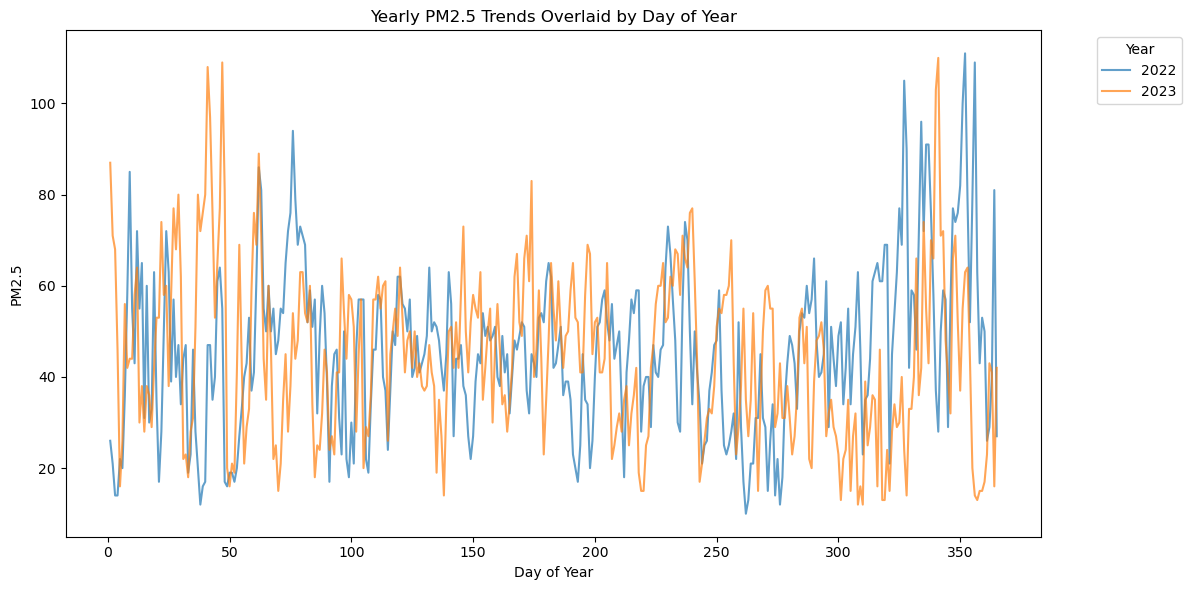

In [18]:
plt.figure(figsize=(12, 6))
for year, group in aqi_df.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

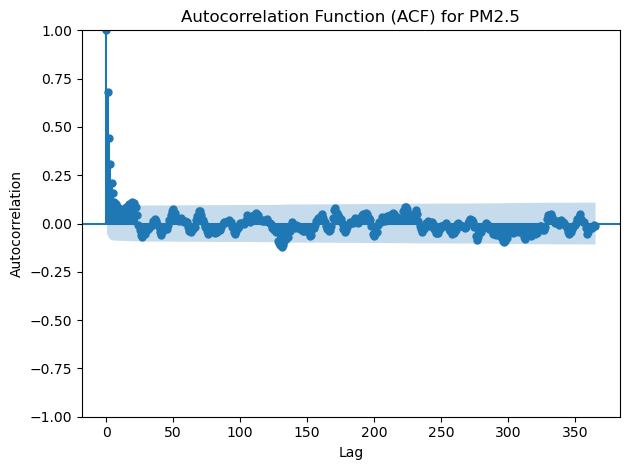

In [19]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_df["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

2025-07-25 14:50:12,741 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-25 14:50:12,751 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


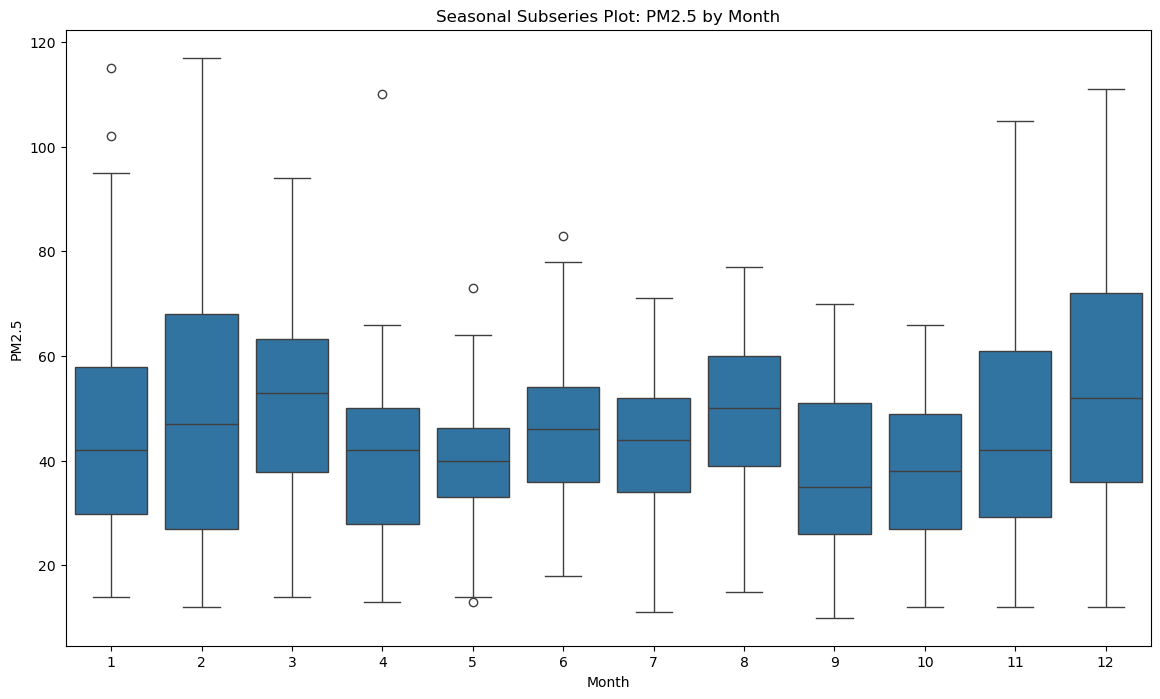

In [20]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_df)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

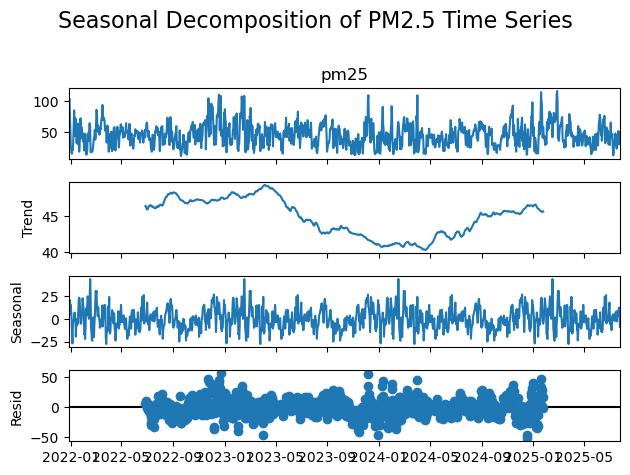

In [21]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_df["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

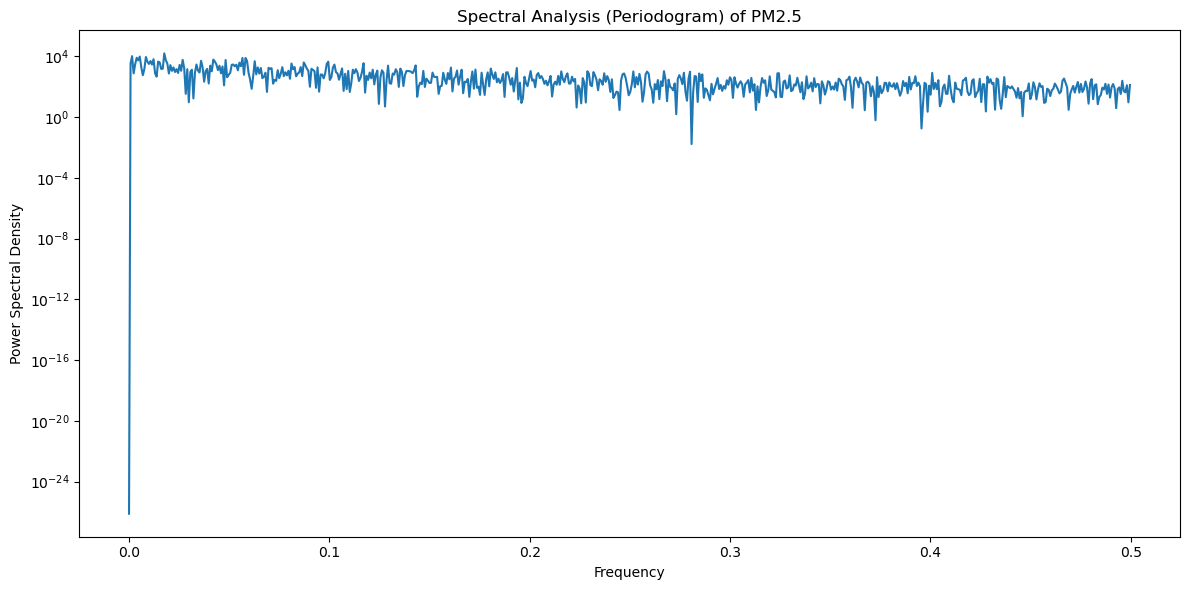

In [22]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_df["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [23]:
train_df, val_df, test_df = split_data(merged_df)

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [24]:
feature_scaler = FeatureScaler()
train_df, val_df, test_df = feature_scaler.fit_transform(train_df, val_df, test_df)

In [25]:
train_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2021-12-27,-0.120095,2.717547,5.009723,-0.673614,5.126476,-2.261882,1.620919,1.285441,-1.499522,1.714016,...,1.0,0.0,-2.549435,-2.610089,-2.247955,-0.462543,-0.044607,-1.442959,-1.422749,-0.865619
2021-12-28,3.203965,2.592513,3.966770,-0.082945,3.235233,-2.261882,1.620919,1.398877,-0.999256,1.723219,...,1.0,0.0,-2.078179,-2.155056,-1.595222,-0.462543,-0.044607,-1.249105,-1.422749,-1.168376
2021-12-29,3.150351,1.342173,2.923818,-1.264282,3.865647,-2.261882,1.620919,1.512312,-0.498989,1.732422,...,1.0,0.0,-1.433303,-1.392207,-1.475555,-0.462543,-0.044607,-1.129810,-1.229738,-1.289478
2021-12-30,1.488321,0.216867,0.577174,-1.264282,3.235233,-2.261882,1.620919,1.625748,0.001277,1.741625,...,1.0,0.0,-1.371296,-1.592957,-1.181825,-0.462543,-0.044607,-1.144722,-1.422749,-0.151115
2021-12-31,0.576885,-1.158506,-0.205040,-1.264282,5.126476,-2.261882,1.620919,1.739183,0.501544,1.750828,...,1.0,0.0,-0.441186,-0.334925,-0.485577,-0.462543,-0.044607,0.421022,0.753983,0.103200


## Prepare prediction windows

In [26]:
(
    X_window_train,
    X_window_val,
    X_window_test,
    y_window_train,
    y_window_val,
    y_window_test,
) = split_to_windows(
    train_df, val_df, test_df, historical_window_size, prediction_window_size
)

In [27]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-10-31,-1.031531,0.216867,0.316436,-0.673614,0.083161,0.941467,1.057434,1.739183,0.001277,1.198638,...,1.0,0.0,0.166486,0.320858,0.091003,-0.462543,-0.044607,0.167520,0.357239,1.035689
2024-11-01,-0.173709,-0.158234,0.055698,-0.673614,-0.547253,0.941467,1.339176,-1.663881,0.501544,1.207841,...,0.0,0.0,0.178887,0.160258,0.450006,-0.462543,-0.044607,-0.011422,0.357239,0.611830
2024-11-02,-0.173709,-0.283268,0.055698,-1.264282,-0.547253,0.941467,1.339176,-1.550446,1.001810,1.217044,...,0.0,0.0,-0.428785,-0.615974,-0.202727,-0.462543,-0.044607,-0.727190,0.357239,0.841925


In [28]:
y_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
2024-11-03,-0.334551,-0.158234,0.577174,-0.673614,0.083161,0.941467,1.339176,-1.437010,1.502077,1.226247,...,0.0,0.0,-0.862836,-1.057624,-0.550851,-0.462543,-0.044607,-0.563160,0.164228,1.568539
2024-11-04,-0.227323,0.591969,1.098651,-1.264282,0.083161,0.941467,1.339176,-1.323575,-1.499522,1.235450,...,1.0,0.0,-0.540398,-0.749808,-0.224484,-0.462543,-0.044607,-0.667543,-0.232516,1.277893
2024-11-05,0.362430,1.342173,1.620127,-0.673614,1.343990,0.941467,1.339176,-1.210139,-0.999256,1.244654,...,1.0,0.0,-0.751223,-0.816724,-0.376789,-0.462543,-0.044607,-1.189458,-1.422749,1.556429


## Training and Evaluation

In [29]:
# Flatten for regressors
X_flat_train, X_flat_val, X_flat_test, y_flat_train, y_flat_val, y_flat_test = flatten_windows(X_window_train, X_window_val, X_window_test, y_window_train, y_window_val, y_window_test)

In [30]:
X_flat_train[-1]

array([-1.03153080e+00,  2.16867416e-01,  3.16436248e-01, -6.73613525e-01,
        8.31610409e-02,  9.41466559e-01,  1.05743386e+00,  1.73918321e+00,
        1.27727637e-03,  1.19863765e+00,  1.20614439e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.66485698e-01,  3.20857977e-01,
        9.10029255e-02, -4.62542631e-01, -4.46068034e-02,  1.67520317e-01,
        3.57238580e-01,  1.03568851e+00, -1.73708928e-01, -1.58234469e-01,
        5.56981053e-02, -6.73613525e-01, -5.47253301e-01,  9.41466559e-01,
        1.33917644e+00, -1.66388136e+00,  5.01543854e-01,  1.20784083e+00,
        1.20614439e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.78887162e-01,  1.60258138e-01,  4.50005717e-01, -4.62542631e-01,
       -4.46068034e-02, -1.14218398e-02,  3.57238580e-01,  6.11830038e-01,
       -1.73708928e-01, -2.83268430e-01,  5.56981053e-02, -1.26428210e+00,
       -5.47253301e-01,  9.41466559e-01,  1.33917644e+00, -1.55044587e+00,
        1.00181043e+00,  

In [31]:
y_flat_train[-1]

array([-0.33455053, -0.15823447,  0.57717439, -0.67361352,  0.08316104,
        0.94146656,  1.33917644, -1.43701038,  1.50207701,  1.22624718,
        1.20614439,  1.        ,  0.        ,  0.        , -0.86283583,
       -1.05762398, -0.55085055, -0.46254263, -0.0446068 , -0.56316016,
        0.1642279 ,  1.56853916, -0.2273228 ,  0.5919693 ,  1.09865068,
       -1.2642821 ,  0.08316104,  0.94146656,  1.33917644, -1.3235749 ,
       -1.49952246,  1.23545036,  1.27071903,  1.        ,  1.        ,
        0.        , -0.54039776, -0.74980762, -0.22448438, -0.46254263,
       -0.0446068 , -0.66754308, -0.23251627,  1.27789335,  0.36242974,
        1.34217307,  1.62012696, -0.67361352,  1.34398973,  0.94146656,
        1.33917644, -1.21013941, -0.99925588,  1.24465354,  1.27071903,
        1.        ,  1.        ,  0.        , -0.75122265, -0.81672422,
       -0.37678859, -0.46254263, -0.0446068 , -1.1894577 , -1.42274878,
        1.55642891])

### Decision Tree

In [32]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_flat_train, y_flat_train)

DecisionTreeRegressor()

In [33]:
y_pred = dt_regressor.predict(X_flat_test)

In [34]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size, original_columns=merged_df.columns)

2025-07-25 14:50:15,227 INFO: Day 1:
2025-07-25 14:50:15,228 INFO: Metrics for Output 1 (pm25):
2025-07-25 14:50:15,229 INFO:   MAE: 0.6868
2025-07-25 14:50:15,232 INFO:   MSE: 0.7492
2025-07-25 14:50:15,234 INFO:   RMSE: 0.8656
2025-07-25 14:50:15,236 INFO:   R2 Score: -0.3449
2025-07-25 14:50:15,237 INFO: --------------------
2025-07-25 14:50:15,238 INFO: Metrics for Output 2 (pm10):
2025-07-25 14:50:15,239 INFO:   MAE: 0.7541
2025-07-25 14:50:15,241 INFO:   MSE: 0.9050
2025-07-25 14:50:15,244 INFO:   RMSE: 0.9513
2025-07-25 14:50:15,246 INFO:   R2 Score: -1.3873
2025-07-25 14:50:15,247 INFO: --------------------
2025-07-25 14:50:15,250 INFO: Metrics for Output 3 (no2):
2025-07-25 14:50:15,251 INFO:   MAE: 0.4611
2025-07-25 14:50:15,252 INFO:   MSE: 0.3745
2025-07-25 14:50:15,254 INFO:   RMSE: 0.6119
2025-07-25 14:50:15,255 INFO:   R2 Score: -0.4621
2025-07-25 14:50:15,257 INFO: --------------------
2025-07-25 14:50:15,257 INFO: Metrics for Output 4 (so2):
2025-07-25 14:50:15,260 INF

In [35]:
# TODO: pandas with column names instead of numpy array

feature_names = []
for i in reversed(range(historical_window_size)):
    for column in merged_df.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

Top 10 important features for Decision Tree:
day_of_year_lag_1d: 0.2054
day_of_year_lag_2d: 0.1139
pm10_lag_1d: 0.0446
pres_lag_1d: 0.0400
day_of_month_lag_1d: 0.0337
so2_lag_1d: 0.0258
tavg_lag_2d: 0.0251
tavg_lag_1d: 0.0245
is_leap_year_lag_2d: 0.0232
tmax_lag_3d: 0.0225


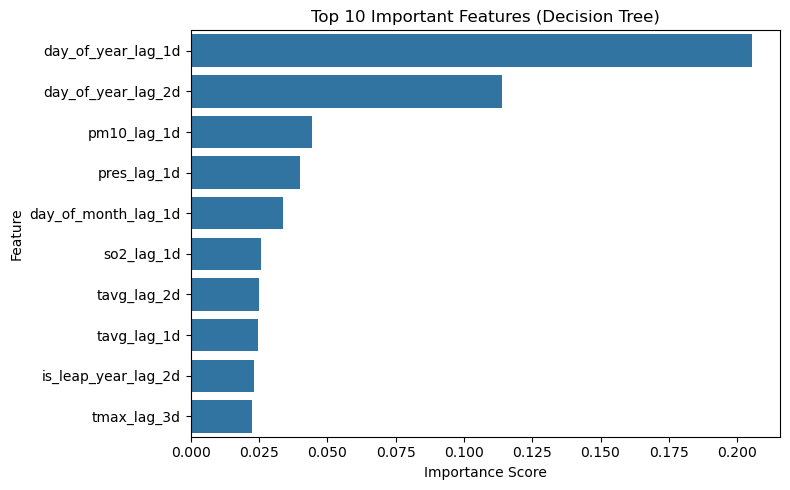

In [36]:
importances = dt_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Decision Tree:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

### Random Forest

In [37]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [38]:
y_pred = rf_regressor.predict(X_flat_test)

In [39]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size, original_columns=merged_df.columns)

2025-07-25 14:50:20,532 INFO: Day 1:
2025-07-25 14:50:20,534 INFO: Metrics for Output 1 (pm25):
2025-07-25 14:50:20,536 INFO:   MAE: 0.5009
2025-07-25 14:50:20,538 INFO:   MSE: 0.4096
2025-07-25 14:50:20,539 INFO:   RMSE: 0.6400
2025-07-25 14:50:20,540 INFO:   R2 Score: 0.2647
2025-07-25 14:50:20,541 INFO: --------------------
2025-07-25 14:50:20,542 INFO: Metrics for Output 2 (pm10):
2025-07-25 14:50:20,543 INFO:   MAE: 0.4867
2025-07-25 14:50:20,544 INFO:   MSE: 0.3684
2025-07-25 14:50:20,545 INFO:   RMSE: 0.6070
2025-07-25 14:50:20,547 INFO:   R2 Score: 0.0281
2025-07-25 14:50:20,548 INFO: --------------------
2025-07-25 14:50:20,552 INFO: Metrics for Output 3 (no2):
2025-07-25 14:50:20,553 INFO:   MAE: 0.3627
2025-07-25 14:50:20,555 INFO:   MSE: 0.2233
2025-07-25 14:50:20,556 INFO:   RMSE: 0.4726
2025-07-25 14:50:20,559 INFO:   R2 Score: 0.1280
2025-07-25 14:50:20,559 INFO: --------------------
2025-07-25 14:50:20,560 INFO: Metrics for Output 4 (so2):
2025-07-25 14:50:20,561 INFO: 

Top 10 important features for Random Forest:
day_of_year_lag_1d: 0.2182
day_of_year_lag_3d: 0.0577
day_of_year_lag_2d: 0.0560
pm10_lag_1d: 0.0443
pres_lag_1d: 0.0372
day_of_month_lag_1d: 0.0347
tmax_lag_1d: 0.0263
so2_lag_1d: 0.0227
tavg_lag_1d: 0.0214
tmax_lag_2d: 0.0187


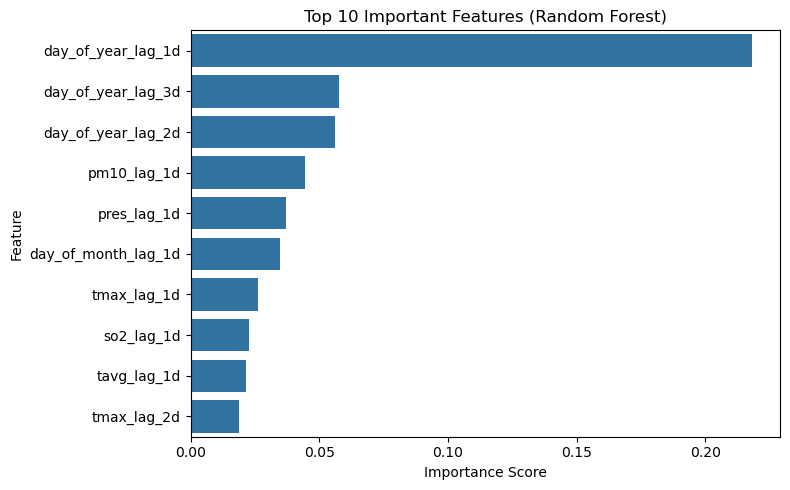

In [40]:
importances = rf_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Random Forest:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [41]:
multi_regressor = create_regressor()
multi_regressor.fit(X_flat_train, y_flat_train)
y_pred = multi_regressor.predict(X_flat_test)
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size, original_columns=merged_df.columns)

2025-07-25 14:50:33,869 INFO: Day 1:
2025-07-25 14:50:33,870 INFO: Metrics for Output 1 (pm25):
2025-07-25 14:50:33,872 INFO:   MAE: 0.2792
2025-07-25 14:50:33,874 INFO:   MSE: 0.1872
2025-07-25 14:50:33,877 INFO:   RMSE: 0.4327
2025-07-25 14:50:33,879 INFO:   R2 Score: 0.6639
2025-07-25 14:50:33,880 INFO: --------------------
2025-07-25 14:50:33,882 INFO: Metrics for Output 2 (pm10):
2025-07-25 14:50:33,884 INFO:   MAE: 0.3954
2025-07-25 14:50:33,885 INFO:   MSE: 0.2542
2025-07-25 14:50:33,887 INFO:   RMSE: 0.5042
2025-07-25 14:50:33,889 INFO:   R2 Score: 0.3295
2025-07-25 14:50:33,890 INFO: --------------------
2025-07-25 14:50:33,891 INFO: Metrics for Output 3 (no2):
2025-07-25 14:50:33,893 INFO:   MAE: 0.3388
2025-07-25 14:50:33,895 INFO:   MSE: 0.1868
2025-07-25 14:50:33,899 INFO:   RMSE: 0.4322
2025-07-25 14:50:33,901 INFO:   R2 Score: 0.2706
2025-07-25 14:50:33,907 INFO: --------------------
2025-07-25 14:50:33,908 INFO: Metrics for Output 4 (so2):
2025-07-25 14:50:33,910 INFO: 

In [42]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(merged_df.columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.3062
 2. pm25_lag_1d          : 0.2180
 3. no2_lag_1d           : 0.0693
 4. tmax_lag_1d          : 0.0304
 5. pres_lag_1d          : 0.0211
 6. month_lag_2d         : 0.0199
 7. week_of_year_lag_2d  : 0.0155
 8. tavg_lag_1d          : 0.0138
 9. day_of_year_lag_1d   : 0.0134
10. pm10_lag_2d          : 0.0132

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1365
 2. pm25_lag_1d          : 0.0444
 3. pm10_lag_2d          : 0.0401
 4. no2_lag_1d           : 0.0389
 5. pres_lag_1d          : 0.0357
 6. pm25_lag_2d          : 0.0279
 7. day_of_week_lag_3d   : 0.0245
 8. wpgt_lag_2d          : 0.0230
 9. day_of_year_lag_1d   : 0.0224
10. day_of_year_lag_2d   : 0.0218

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.2163
 2. tavg_lag_1d          : 0.0830
 3. week_of_year_lag_2d  : 0.0513
 4. tmin_lag_1d          : 0.0341
 5. day_of_year_lag_1d   : 0.0322
 6. year_lag_1d          : 0.0310
 7. day_of_year_lag_2d   : 0.0258
 8. mont

### Neural Networks

In [43]:
class EarlyStopping:
    """Early stopping utility to monitor validation loss and save best weights"""

    def __init__(self, patience=10, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights

        self.best_loss = float("inf")
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss improved
            self.best_loss = val_loss
            self.counter = 0
            # Save best weights
            if self.restore_best_weights:
                self.best_weights = {
                    k: v.clone().detach() for k, v in model.state_dict().items()
                }
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def restore_best_weights_to_model(self, model):
        """Restore the best weights to the model"""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)
            print(f"Restored best weights (val_loss: {self.best_loss:.6f})")

In [44]:
# Prepare data for LSTM: convert windowed data to tensors
def windows_to_tensor(X_windows, y_windows):
    # X: list of DataFrames, each (window_size, num_features)
    # y: list of DataFrames, each (prediction_window_size, num_targets)
    X_tensor = torch.tensor(
        np.stack([x.values for x in X_windows]), dtype=torch.float32
    )
    y_tensor = torch.tensor(
        np.stack([y.values for y in y_windows]), dtype=torch.float32
    )
    return X_tensor, y_tensor

In [45]:
X_lstm_train, y_lstm_train = windows_to_tensor(X_window_train, y_window_train)
X_lstm_val, y_lstm_val = windows_to_tensor(X_window_val, y_window_val)
X_lstm_test, y_lstm_test = windows_to_tensor(X_window_test, y_window_test)

In [46]:
X_lstm_train.shape

torch.Size([1040, 3, 22])

In [47]:
y_lstm_train.shape

torch.Size([1040, 3, 22])

In [48]:
class LSTMRegressor(nn.Module):

    def __init__(
        self, input_dim, hidden_dim, output_dim, num_layers=1, prediction_window_size=3
    ):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim * prediction_window_size)
        
        self.output_dim = output_dim
        self.prediction_window_size = prediction_window_size

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Use last hidden state for prediction
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.fc(out)
        # Reshape to (batch, prediction_window_size, output_dim)
        out = out.view(-1, self.prediction_window_size, self.output_dim)
        return out

In [49]:
input_dim = X_lstm_train.shape[2]
output_dim = y_lstm_train.shape[2]
hidden_dim = 64
num_layers = 2
prediction_window_size = y_lstm_train.shape[1]

model = LSTMRegressor(
    input_dim, hidden_dim, output_dim, num_layers, prediction_window_size
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=1e-6)

# Training loop
epochs = 100
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_lstm_train.size(0))
    epoch_loss = 0
    for i in range(0, X_lstm_train.size(0), batch_size):
        idx = permutation[i : i + batch_size]
        batch_X, batch_y = X_lstm_train[idx], y_lstm_train[idx]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= X_lstm_train.size(0)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_lstm_val)
        val_loss = criterion(val_output, y_lstm_val).item()
    
    # Print progress
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Best Val: {early_stopping.best_loss:.6f}"
    )
    
    # Early stopping check
    if early_stopping(val_loss, model):
        best_epoch = epoch + 1 - early_stopping.patience
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best epoch was {best_epoch} with val_loss: {early_stopping.best_loss:.6f}")
        break

    # Update best epoch if this is the best so far
    if val_loss == early_stopping.best_loss:
        best_epoch = epoch + 1

# Restore best weights
early_stopping.restore_best_weights_to_model(model)

# Training completed
final_status = "Early stopped" if early_stopping.early_stop else "Completed"
print(f"\nTraining {final_status.lower()} after {epoch + 1} epochs")
print(f"Best validation loss: {early_stopping.best_loss:.6f} at epoch {best_epoch}")

Epoch 1/100 | Train Loss: 1.0094 | Val Loss: 1.1700 | Best Val: inf
Epoch 2/100 | Train Loss: 0.7810 | Val Loss: 0.9933 | Best Val: 1.169950
Epoch 3/100 | Train Loss: 0.6889 | Val Loss: 0.7927 | Best Val: 0.993288
Epoch 4/100 | Train Loss: 0.6396 | Val Loss: 0.6882 | Best Val: 0.792701
Epoch 5/100 | Train Loss: 0.6020 | Val Loss: 0.6223 | Best Val: 0.688154
Epoch 6/100 | Train Loss: 0.5738 | Val Loss: 0.6052 | Best Val: 0.622327
Epoch 7/100 | Train Loss: 0.5532 | Val Loss: 0.5968 | Best Val: 0.605187
Epoch 8/100 | Train Loss: 0.5362 | Val Loss: 0.5887 | Best Val: 0.596768
Epoch 9/100 | Train Loss: 0.5182 | Val Loss: 0.5733 | Best Val: 0.588693
Epoch 10/100 | Train Loss: 0.5114 | Val Loss: 0.5853 | Best Val: 0.573255
Epoch 11/100 | Train Loss: 0.4968 | Val Loss: 0.5719 | Best Val: 0.573255
Epoch 12/100 | Train Loss: 0.4870 | Val Loss: 0.5929 | Best Val: 0.571938
Epoch 13/100 | Train Loss: 0.4807 | Val Loss: 0.5773 | Best Val: 0.571938
Epoch 14/100 | Train Loss: 0.4753 | Val Loss: 0.5733

In [50]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_lstm_test).cpu().numpy()
    y_true_lstm = y_lstm_test.cpu().numpy()

# Flatten for metric calculation (same as previous evaluate_predictions)
y_pred_flat = y_pred_lstm.reshape(y_pred_lstm.shape[0], -1)
y_true_flat = y_true_lstm.reshape(y_true_lstm.shape[0], -1)

evaluate_predictions(
    y_true=y_true_flat, y_pred=y_pred_flat, window_size=prediction_window_size, original_columns=merged_df.columns
)

2025-07-25 14:50:39,679 INFO: Day 1:
2025-07-25 14:50:39,680 INFO: Metrics for Output 1 (pm25):
2025-07-25 14:50:39,684 INFO:   MAE: 0.3893
2025-07-25 14:50:39,688 INFO:   MSE: 0.2657
2025-07-25 14:50:39,691 INFO:   RMSE: 0.5155
2025-07-25 14:50:39,695 INFO:   R2 Score: 0.5231
2025-07-25 14:50:39,696 INFO: --------------------
2025-07-25 14:50:39,697 INFO: Metrics for Output 2 (pm10):
2025-07-25 14:50:39,701 INFO:   MAE: 0.4202
2025-07-25 14:50:39,704 INFO:   MSE: 0.2714
2025-07-25 14:50:39,706 INFO:   RMSE: 0.5209
2025-07-25 14:50:39,709 INFO:   R2 Score: 0.2842
2025-07-25 14:50:39,710 INFO: --------------------
2025-07-25 14:50:39,711 INFO: Metrics for Output 3 (no2):
2025-07-25 14:50:39,713 INFO:   MAE: 0.3628
2025-07-25 14:50:39,715 INFO:   MSE: 0.2079
2025-07-25 14:50:39,717 INFO:   RMSE: 0.4560
2025-07-25 14:50:39,720 INFO:   R2 Score: 0.1883
2025-07-25 14:50:39,735 INFO: --------------------
2025-07-25 14:50:39,737 INFO: Metrics for Output 4 (so2):
2025-07-25 14:50:39,739 INFO: 

## Real world prediction

In [51]:
# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X = feature_scaler.transform(X)

for day in range(num_of_predictions):
    # Input expects multiple windows
    X_flat = _flatten_windows([X])

    y_pred = multi_regressor.predict(X_flat)

    # Split y_pred into 3 arrays, one for each prediction day
    y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

    # Create DataFrame for predictions, each row is a prediction day
    predictions_df = pd.DataFrame(y_pred_split, columns=merged_df.columns)

    # Set the index to continue from the last date in merged_df
    last_date = X.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
    predictions_df.index = future_dates

    # Add predictions to the end so that we can use them as input (don't forget to remove the same number of items as we added - model expects certain size)
    X = pd.concat([X[prediction_window_size:], predictions_df], axis=0)

X = feature_scaler.inverse_transform(X)

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
iaqi_features = ["pm25", "pm10", "no2", "so2", "co"]
X["aqi"] = X[iaqi_features].max(axis=1)

print(X[-num_of_predictions*prediction_window_size:][iaqi_features])

2025-07-25 14:50:40,459 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-07-25 14:50:40,517 WARNING: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

                 pm25       pm10       no2       so2        co
2025-07-26  27.394077  23.778400  7.700122  5.710533  3.258347
2025-07-27  49.410110  25.355598  5.711646  3.639757  2.945915
2025-07-28  59.127773  19.430532  6.997982  2.826176  3.522528
